# Planning Methods: Part II, Spring 2023

# Lab 5: Logistic Regressions

**About This Lab**
* This lab uses the following file in the same directory with this notebook:
    * `model_property_data.csv`
* This data includes properties that were sold through a real estate site (like Zillow) between 2001 and 2006 in Bogota. There are apartments and houses, characteristics of the structure like area and bathrooms, and characteristics of the neighborhood like density and a proxy for neighborhood income which is called SES.

## Objectives

You will also learn how to:
>1. Run a logistic regression and compare results with linear regression
>2. Analyze odds ratios
>3. Plot predicted probabilities

## 1 Import packages, load & clean data

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.discrete_model import Logit  

In [2]:
data = pd.read_csv('model_property_data.csv')

data.head()

,Unnamed: 0,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,thefts,year,high_ses,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006
0,0,60000,830.78,4,0,70,2,1.74,39.92,2001,0,1,0,0,0,0,0
1,1,140000,826.75,4,1,257,4,0.54,46.00,2002,0,0,1,0,0,0,0
2,2,38000,914.15,4,0,115,4,1.55,45.87,2002,0,0,1,0,0,0,0
3,3,110000,911.25,4,1,270,4,1.58,45.88,2002,0,0,1,0,0,0,0
4,4,120000,757.37,4,1,268,2,0.40,46.00,2002,0,0,1,0,0,0,0


Remember - logistic regressions are used when the **dependent** variable is a dummy variable (0 or 1). In this case, we are going to transform our price into a dummy variable, using the median as cutoff.

## 2 Create dependent variable

In [3]:
# identify dummy threshold
price_median = data['price_000'].median()
print(price_median)

# create dummy dependent variable
data['high_price'] = np.where(data['price_000']>price_median, 1, 0)
data.head()

72000.0


,Unnamed: 0,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,thefts,year,high_ses,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006,high_price
0,0,60000,830.78,4,0,70,2,1.74,39.92,2001,0,1,0,0,0,0,0,0
1,1,140000,826.75,4,1,257,4,0.54,46.00,2002,0,0,1,0,0,0,0,1
2,2,38000,914.15,4,0,115,4,1.55,45.87,2002,0,0,1,0,0,0,0,0
3,3,110000,911.25,4,1,270,4,1.58,45.88,2002,0,0,1,0,0,0,0,1
4,4,120000,757.37,4,1,268,2,0.40,46.00,2002,0,0,1,0,0,0,0,1


In [4]:
data['high_price'].value_counts()

0    2003
1    1973
Name: high_price, dtype: int64

### 2.1 Run Multivariable regression
First, let's run a multivariable regression with high_price dummy variable. 

In [5]:
# define independent variables
ind_var = ['high_ses', 'house', 'area_m2', 'num_bath', 'pcn_green', 
           'thefts','yr_2002','yr_2003','yr_2004','yr_2005','yr_2006'] 
# note that the year variable is categorical so we need to exclude one to prevent collinearity 
# within our model - we will exclude year 2001 - we chose to have the earlier year be our base year

x = data[ind_var].assign(Intercept = 1) # independent variables
y = data['high_price'] # dependent variable

model = sm.OLS(y, x).fit()
# save the results as "model" - this will be useful for other functions below.

model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.393    
Dependent Variable: high_price       AIC:                3802.0099
Date:               2023-02-23 14:20 BIC:                3877.4663
No. Observations:   3976             Log-Likelihood:     -1889.0  
Df Model:           11               F-statistic:        234.6    
Df Residuals:       3964             Prob (F-statistic): 0.00     
R-squared:          0.394            Scale:              0.15188  
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
high_ses        0.2636    0.0236  11.1555  0.0000   0.2173   0.3099
house           0.0712    0.0183   3.8911  0.0001   0.0353   0.1070
area_m2         0.0024    0.0001  22.3542  0.0000   0.0022   0.0026
num_bath        0.0901    0.0072  12.5483  0.0000   0.0760   0.1042
pcn_green       0.0075    0.0009   8.7190  0.0000   0.0059   0.0092
thefts         -0.0010    0.0001  -7.9428  0.0000  -0.0012  -0.0007
yr_2002        -0.0406    0.0239  -1.6993  0.0893  -0.0874   0.0062
yr_2003         0.0502    0.0229   2.1916  0.0285   0.0053   0.0951
yr_2004         0.0546    0.0206   2.6475  0.0081   0.0142   0.0950
yr_2005         0.0929    0.0215   4.3271  0.0000   0.0508   0.1350
yr_2006         0.1897    0.0241   7.8743  0.0000   0.1425   0.2369
Intercept      -0.0387    0.0245  -1.5765  0.1150  -0.0868   0.0094
------------------------------------------------------------------
Omnibus:             569.409       Durbin-Watson:          0.694  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       186.836
Skew:                0.289         Prob(JB):               0.000  
Kurtosis:            2.109         Condition No.:          1182   
==================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

## 3 Logistic regression (aka logit model)

Logistics regression equation (1): $$ln(P_i/1-P_i) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n$$

$$P(y = 1|x) = P_i = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n)}}$$ <br>

### 3.1 Run logit model

In [6]:
y = data['high_price'] # dependent variable - it's a dummy!
x = data[ind_var].assign(Intercept = 1) # independent variables - same list as before

# define and run logit model
logit_model = Logit(y, x).fit()
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.410658
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.408    
Dependent Variable: high_price       AIC:              3289.5511
Date:               2023-02-23 14:27 BIC:              3365.0074
No. Observations:   3976             Log-Likelihood:   -1632.8  
Df Model:           11               LL-Null:          -2755.8  
Df Residuals:       3964             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
high_ses     1.7720    0.1970    8.9932  0.0000   1.3858   2.1582
house       -0.3467    0.1312   -2.6433  0.0082  -0.6039  -0.0896
area_m2      0.0289    0.0014   20.8734  0.0000   0.0262   0.0316
num_bath     0.6346    0.0571   11.1054  0.0000   0.5226   0.7465
pcn_green    0.0426    0.0056    7.5450  0.0000   0.0315   0.0537
thefts      -0.0059    0.0009   -6.2730  0.0000  -0.0077  -0.0041
yr_2002     -0.1936    0.1786   -1.0842  0.2783  -0.5436   0.1564
yr_2003      0.5769    0.1704    3.3855  0.0007   0.2429   0.9108
yr_2004      0.5040    0.1507    3.3441  0.0008   0.2086   0.7995
yr_2005      0.9488    0.1555    6.1027  0.0000   0.6441   1.2535
yr_2006      1.5429    0.1697    9.0942  0.0000   1.2103   1.8754
Intercept   -4.6274    0.2231  -20.7368  0.0000  -5.0647  -4.1900
================================================================

"""

In logistic regression the coefficients derived from the model (e.g., $\beta_1$) indicate the change in the expected log odds relative to a one unit change in $x_1$, holding all other predictors constant. Therefore, the antilog of an estimated regression coefficient, $\exp(\beta_i)$, produces an odds ratio.

log transformation of equation (1): $$P_i/(1-P_i) = e^{ \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n} = e^{\beta_0} * e^{\beta_1*x_1} * e^{\beta_2*x_2}* \cdots  *e^{\beta_n*x_n}$$


Therefore, we have odds ratio 
$$OR = e^{\beta_i}$$


### 3.2 Display odds ratios

In [9]:
# odds ratios
or_table = np.exp(logit_model.conf_int()) # exponentiate confidence intervals
or_table['Odds Ratio'] = np.exp(logit_model.params) # exponentiate coefficients

or_table.columns = ['2.5%', '97.5%', 'Odds Ratio'] # name columns
or_table

,2.5%,97.5%,Odds Ratio
high_ses,3.998069,8.655421,5.882599
house,0.546701,0.914263,0.706985
area_m2,1.026550,1.032140,1.029341
num_bath,1.686351,2.109708,1.886189
pcn_green,1.032034,1.055128,1.043517
thefts,0.992298,0.995958,0.994126
yr_2002,0.580653,1.169267,0.823977
yr_2003,1.274952,2.486408,1.780463
yr_2004,1.231980,2.224358,1.655405
yr_2005,1.904214,3.502556,2.582560


## 4 Plot predicted probabilities

In [10]:
data['num_bath'].unique()

array([2, 4, 3, 1, 5])

In [11]:
# predicted probabilities
df_predict = data.copy()
df_predict['pred_high_price'] = logit_model.predict(x)

df_predict['pred_high_price']

0       0.183173
1       0.989591
2       0.698192
3       0.993143
4       0.973342
          ...   
3971    0.999763
3972    0.994266
3973    0.367966
3974    0.964960
3975    0.848230
Name: pred_high_price, Length: 3976, dtype: float64

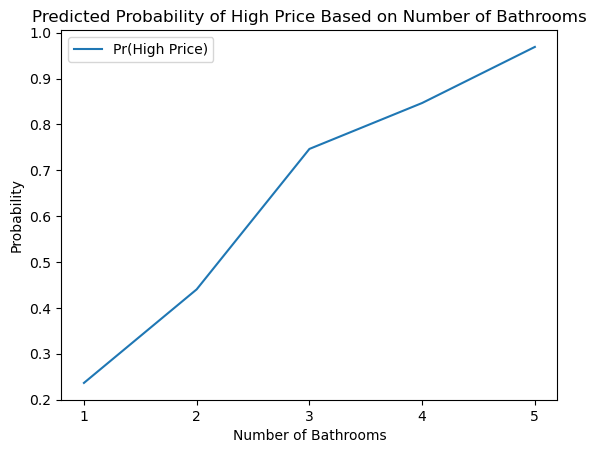

In [12]:
# plot probabilities by key independent variable
df_predict2 = df_predict.groupby(by = 'num_bath').agg(np.mean)[['pred_high_price']]
df_predict2.plot();

# plot with labels
plt.title('Predicted Probability of High Price Based on Number of Bathrooms')
plt.xlabel('Number of Bathrooms'),
plt.ylabel('Probability'),
positions = (1, 2, 3, 4, 5)
labels = ('1', '2', '3', '4', '5')
plt.xticks(positions, labels)
legend = ['Pr(High Price)']
plt.legend(legend);

In [13]:
df_predict2

,pred_high_price
num_bath,
1,0.236431
2,0.440390
3,0.746484
4,0.846621
5,0.968861


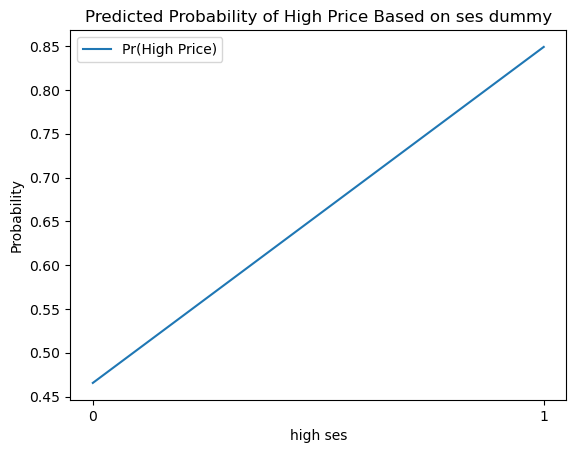

In [14]:
# plot probabilities by key independent variable
df_predict2 = df_predict.groupby(by = 'high_ses').agg(np.mean)[['pred_high_price']]
df_predict2.plot();

# plot with labels
plt.title('Predicted Probability of High Price Based on ses dummy')
plt.xlabel('high ses'),
plt.ylabel('Probability'),
positions = (0, 1)
labels = ('0', '1')
plt.xticks(positions, labels)
legend = ['Pr(High Price)']
plt.legend(legend);

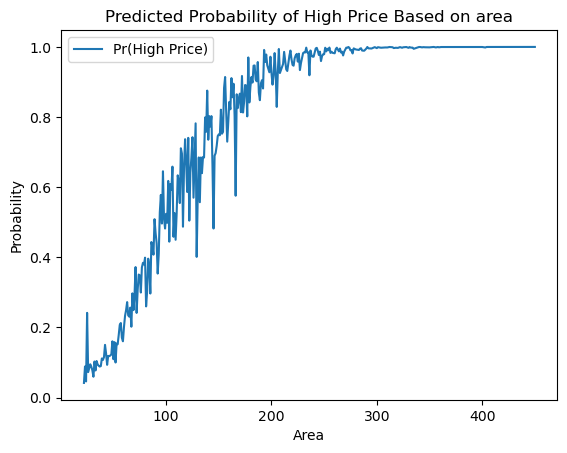

In [15]:
# plot probabilities by key independent variable
df_predict2 = df_predict.groupby(by = 'area_m2').agg(np.mean)[['pred_high_price']]
df_predict2.plot();

# plot with labels
plt.title('Predicted Probability of High Price Based on area')
plt.xlabel('Area'),
plt.ylabel('Probability'),
# positions = (1, 2, 3, 4, 5)
# labels = ('1', '2', '3', '4', '5')
# plt.xticks(positions, labels)
legend = ['Pr(High Price)']
plt.legend(legend);

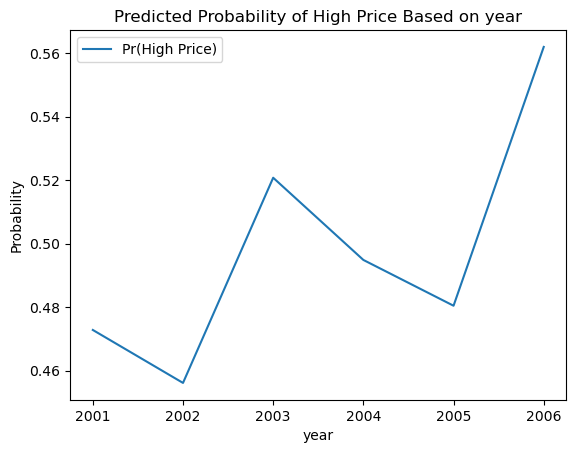

In [16]:
# plot probabilities by key independent variable
df_predict2 = df_predict.groupby(by = 'year').agg(np.mean)[['pred_high_price']]
df_predict2.plot();

# plot with labels
plt.title('Predicted Probability of High Price Based on year')
plt.xlabel('year'),
plt.ylabel('Probability'),
# positions = (1, 2, 3, 4, 5)
# labels = ('1', '2', '3', '4', '5')
# plt.xticks(positions, labels)
legend = ['Pr(High Price)']
plt.legend(legend);